In [5]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import seaborn as sns
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc

from source import online_streaming_clustering as on_sc

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    for l in lista:
        if l in string:
            return True
    return False

In [11]:
logs = insensitive_glob("process_mining_datasets/*/*k.MXML")

In [12]:
logs = [x for x in logs if "2.5" not in x]

### Read and Prep log file

In [1]:
#Example
# logs[1]

In [14]:
log_read = pm.all_prep(logs[1])
tokens = lr.get_traces_as_tokens(log_read)
y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))

### Vector space representations

In [17]:
activity_binary = lr.get_binary_representation(tokens)
transitions_binary = lr.get_binary_transitions_representation(tokens)
activity_frequency = lr.get_frequency_representation(tokens)

### Trace Clustering - Transitions Binary

In [22]:
run_df = on_sc.run_online_streaming_clustering(
    model_name='MOACluStream', 
    model_parameters={'h':150, 'k_macro': 3, 'm':30, 't': 2}, 
    df=transitions_binary, 
    use_tqdm=True, expand_weights=False, get_macro_clusters=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

##### Features from the evolution of trace clustering

In [24]:
run_df.columns

Index(['col_names', 'micro', 'micro_ids', 'micro_radius', 'micro_weights',
       'outliers', 'outliers_ids', 'outliers_radius', 'outliers_weights',
       'macro', 'macro_weights', 'macro_radius', 'FITS_EXISTING_MICROCLUSTER',
       'FORGET_OLD_MICROCLUSTER', 'MERGED_MICROCLUSTER',
       'AVG__micro_interclusters_distance',
       'STD__micro_interclusters_distance',
       'AVG__micro_interclusters_jaccard_distance',
       'AVG__micro_interclusters_cosine_distance',
       'AVG__micro_interclusters_MSE',
       'AVG__micro_interclusters_countnonzero_MSE',
       'AVG__micro_centroids_dimensions_std', 'AVG__micro_centroids_std',
       'SSQ__micro_centroids', 'AVG__micro_radius', 'AVG__micro_weights',
       'AVG__macro_interclusters_distance',
       'STD__macro_interclusters_distance',
       'AVG__macro_interclusters_jaccard_distance',
       'AVG__macro_interclusters_cosine_distance',
       'AVG__macro_interclusters_MSE',
       'AVG__macro_interclusters_countnonzero_MSE',
   

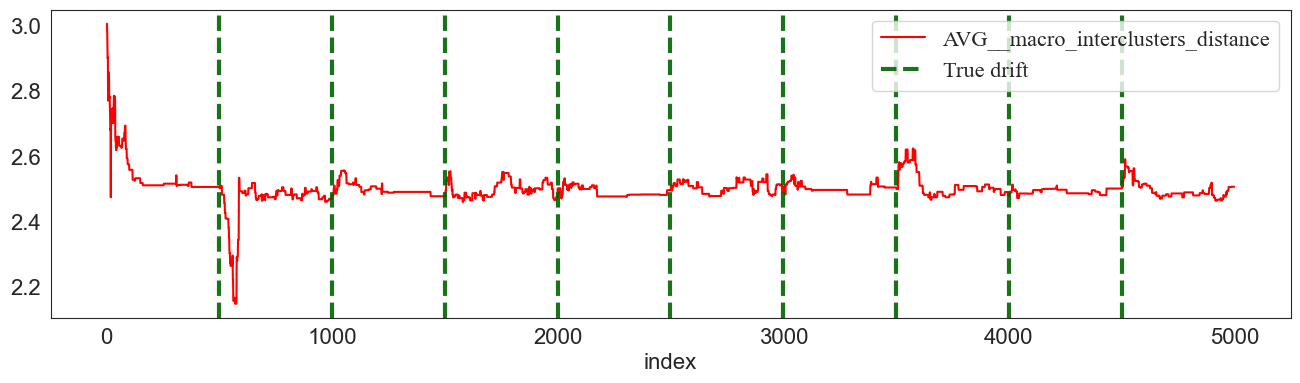

In [25]:
run_df['AVG__macro_interclusters_distance'].plot(figsize=(16,4), c='red')
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

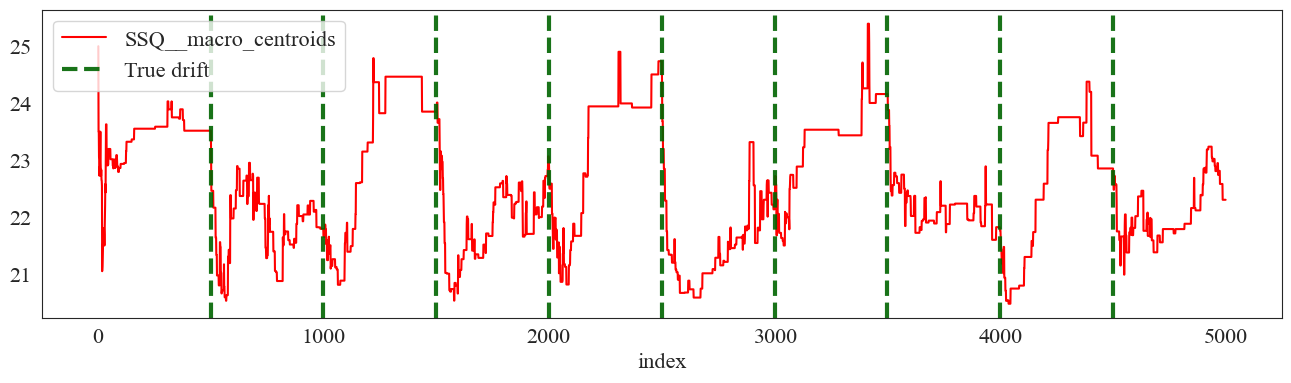

In [26]:
run_df['SSQ__macro_centroids'].plot(figsize=(16,4), c='red')
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

### Drift Detection

In [47]:
clustering_window_size = 150

In [37]:
drifts, info = dd.detect_concept_drift(
    run_df,
    'SSQ__macro_centroids',
    rolling_window=200,
    std_tolerance=1.5,
    min_tol=0.03
)

In [48]:
dd.get_metrics(drifts, y_true, window_size=clustering_window_size)

{'Precision': 0.47058823529411764,
 'Recall': 0.8888888888888888,
 'F1': 0.6153846153846154,
 'Delay': 76.375,
 'Correct_Predictions': [1, 1, 1, 1, 1, 1, 1, 1, 0],
 'Support': 8,
 'Drifts_Found': [503,
  778,
  1032,
  1233,
  1515,
  1752,
  1996,
  2197,
  2505,
  2751,
  3098,
  3388,
  3604,
  3935,
  4157,
  4383,
  4859],
 'Resp': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]}

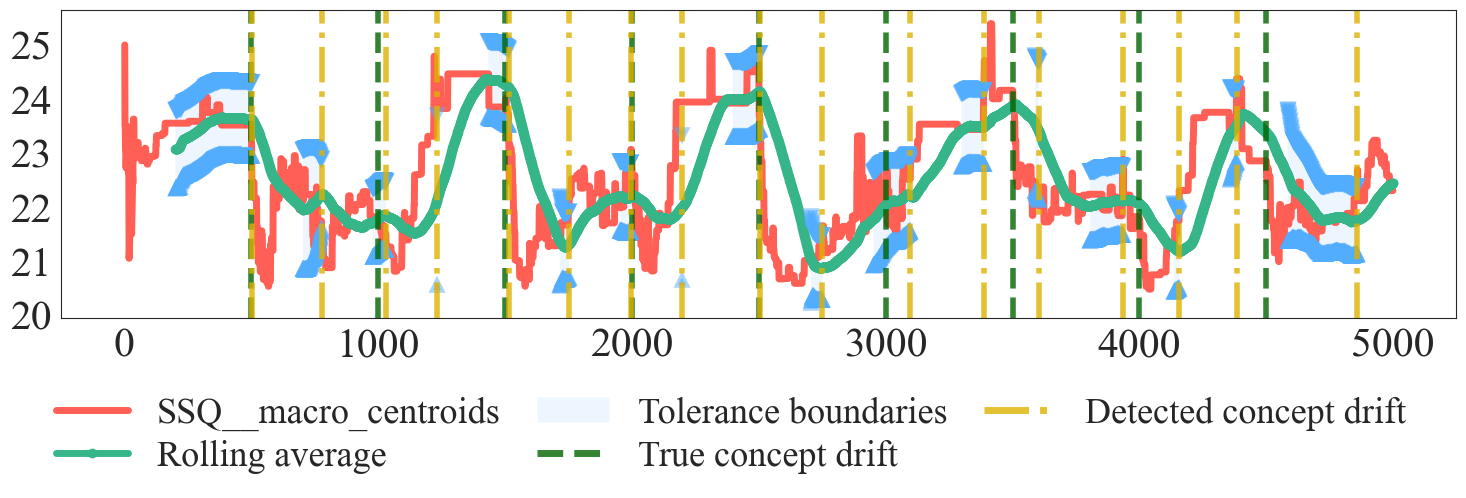

In [41]:
plts.plot_deteccao_drift(
    run_df,
    'SSQ__macro_centroids',
    drifts,
    y_true,
    info['means'],
    info['lowers'],
    info['uppers'],
    save_png=""
)

### Drift Localization

In [50]:
run_df = run_df.rename(columns={'macro': 'centroids'})

In [51]:
dl.localize_drift(
    run_df.centroids.loc[500], 
    run_df.centroids.loc[625], 
    transitions_binary.columns
)

,0
Assess_eligibility Check_if_home_insurance_quote_is_requested,0.688981
Prepare_acceptance_pack Check_if_home_insurance_quote_is_requested,0.535301
Assess_eligibility Prepare_acceptance_pack,0.535301
Reject_application Loan_application_rejected,0.277523
Assess_eligibility Reject_application,0.277523
Appraise_property Assess_eligibility,0.231481
Assess_loan_risk Appraise_property,0.231481
Assess_loan_risk Assess_eligibility,0.231481
Check_credit_history Assess_loan_risk,0.120370
Check_credit_history Appraise_property,0.120370


In [52]:
# Result of drift localization in the ground truth drifts

dl.localize_all_drifts(
    run_df,
    [x + clustering_window_size for x in y_true], 
    clustering_window_size,
    transitions_binary.columns
)

,drift_at_650,drift_at_1150,drift_at_1650,drift_at_2150,drift_at_2650,drift_at_3150,drift_at_3650,drift_at_4150,drift_at_4650
Assess_eligibility Check_if_home_insurance_quote_is_requested,0.693630,0.403134,0.491200,0.563162,0.348346,0.510715,0.494417,0.387095,0.486746
Prepare_acceptance_pack Check_if_home_insurance_quote_is_requested,0.670782,0.403134,0.540000,0.376430,0.398449,0.410308,0.499966,0.329736,0.449237
Assess_eligibility Prepare_acceptance_pack,0.670782,0.403134,0.540000,0.376430,0.398449,0.410308,0.499966,0.329736,0.449237
Appraise_property Assess_loan_risk,0.231481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Check_credit_history Appraise_property,0.231481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Check_credit_history Assess_loan_risk,0.231481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Reject_application Loan_application_rejected,0.207734,0.000000,0.001314,0.020623,0.004356,0.007118,0.012785,0.006444,0.006585
Assess_eligibility Reject_application,0.207734,0.000000,0.001314,0.020623,0.004356,0.007118,0.012785,0.006444,0.006585
Assess_loan_risk Assess_eligibility,0.120370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Assess_loan_risk Appraise_property,0.120370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
# Result of drift localization in all predicted drifts

dl.localize_all_drifts(
    run_df,
    drifts, 
    clustering_window_size,
    transitions_binary.columns
)

,drift_at_503,drift_at_778,drift_at_1032,drift_at_1233,drift_at_1515,drift_at_1752,drift_at_1996,drift_at_2197,drift_at_2505,drift_at_2751,drift_at_3098,drift_at_3388,drift_at_3604,drift_at_3935,drift_at_4157,drift_at_4383,drift_at_4859
Assess_eligibility Check_if_home_insurance_quote_is_requested,0.013333,0.007749,0.068173,0.112604,0.015254,0.012097,0.005544,0.194105,0.011738,0.046223,0.452019,0.000000,0.413738,0.002342,0.259232,0.000132,0.019267
Assess_eligibility Prepare_acceptance_pack,0.013333,0.007523,0.057789,0.134105,0.025968,0.002755,0.000000,0.134396,0.010408,0.020135,0.406654,0.003333,0.440102,0.000000,0.285631,0.012980,0.000000
Prepare_acceptance_pack Check_if_home_insurance_quote_is_requested,0.013333,0.007523,0.057789,0.134105,0.025968,0.002755,0.000000,0.134396,0.010408,0.020135,0.406654,0.003333,0.440102,0.000000,0.285631,0.012980,0.000000
Return_application_back_to_applicant Receive_updated_application,0.010568,0.030106,0.026940,0.064223,0.006064,0.011372,0.004166,0.070655,0.010571,0.001285,0.003029,0.003333,0.010264,0.004845,0.003966,0.008027,0.004241
Receive_updated_application Check__application__form_completeness,0.010568,0.030106,0.026940,0.064223,0.006064,0.011372,0.004166,0.070655,0.010571,0.001285,0.003029,0.003333,0.010264,0.004845,0.003966,0.008027,0.004241
Check__application__form_completeness Return_application_back_to_applicant,0.010568,0.030106,0.026940,0.064223,0.006064,0.011372,0.004166,0.070655,0.010571,0.001285,0.003029,0.003333,0.010264,0.004845,0.003966,0.008027,0.004241
Check_if_home_insurance_quote_is_requested Send_home_insurance_quote,0.009718,0.014497,0.011564,0.006165,0.004680,0.010973,0.010305,0.013579,0.023164,0.011666,0.001233,0.003333,0.021365,0.000496,0.009496,0.000910,0.017003
Check_if_home_insurance_quote_is_requested Send_acceptance_pack,0.006384,0.000424,0.026852,0.020067,0.008305,0.008293,0.024657,0.005323,0.017870,0.005816,0.031359,0.000000,0.033503,0.001598,0.046380,0.016706,0.000676
Send_acceptance_pack Verify_repayment_agreement,0.006384,0.000424,0.026852,0.020067,0.008305,0.008293,0.024657,0.005323,0.017870,0.005816,0.031359,0.000000,0.033503,0.001598,0.046380,0.016706,0.000676
Send_home_insurance_quote Verify_repayment_agreement,0.006384,0.010331,0.001482,0.011647,0.001099,0.015794,0.002075,0.002859,0.012218,0.002075,0.017694,0.003333,0.010718,0.006419,0.012310,0.000910,0.002078
